# Import des librairies

In [1]:
import tensorflow as tf 
import tensorboard
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

C:\Users\charlene.dupont.JWA\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\charlene.dupont.JWA\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\charlene.dupont.JWA\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import os 
print(os.getcwd())

C:\Users\charlene.dupont.JWA\OneDrive - Optimind\Perso 2020\jEDHA\Projet


# Import des données

In [3]:
import pathlib 
ds_mask = pathlib.Path("C:/Users/charlene.dupont.JWA/OneDrive - Optimind/Perso 2020/jEDHA/Projet/Mask_total")
ds_no_mask = pathlib.Path("C:/Users/charlene.dupont.JWA/OneDrive - Optimind/Perso 2020/jEDHA/Projet/Visages")

# Convert all paths mask into a string
ds_mask_paths = [str(img_path) for img_path in list(ds_mask.glob("*.jpg"))]
print(ds_mask_paths[:3])
mask_size = len(ds_mask_paths)
print("Taille de l'échantillon : ",mask_size)


# Convert all paths no mask into a string
ds_no_mask_paths = [str(img_path) for img_path in list(ds_no_mask.glob("*.jpg"))]
nomask_size = len(ds_no_mask_paths)
print("Taille de l'échantillon : ",nomask_size)

#Agrégation
ds_paths = ds_mask_paths
ds_paths.extend(ds_no_mask_paths)
ds_size = len(ds_paths)
print("Taille de l'échantillon : ",ds_size)



['C:\\Users\\charlene.dupont.JWA\\OneDrive - Optimind\\Perso 2020\\jEDHA\\Projet\\Mask_total\\face mask covid_1.jpg', 'C:\\Users\\charlene.dupont.JWA\\OneDrive - Optimind\\Perso 2020\\jEDHA\\Projet\\Mask_total\\face mask covid_10.jpg', 'C:\\Users\\charlene.dupont.JWA\\OneDrive - Optimind\\Perso 2020\\jEDHA\\Projet\\Mask_total\\face mask covid_100.jpg']
Taille de l'échantillon :  1139
Taille de l'échantillon :  1217
Taille de l'échantillon :  2356


In [5]:
# Conversion des chemins en bytes
ds_bytes = [tf.io.read_file(path) for path in ds_paths]

# Conversion des bytes en tensor
ds_tensors = [tf.image.decode_jpeg(img_byte) for img_byte in ds_bytes]

#Visualisation d'une image
plt.imshow(ds_tensors[0])

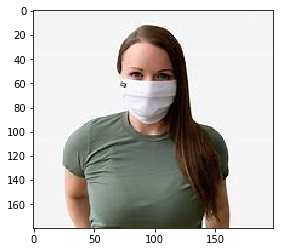

In [6]:
plt.imshow(ds_tensors[0])
plt.show()

# Preprocess the images and data augmentation 

In [7]:
# Creation of preprocessing function
def load_and_resize_images(path):
    img = tf.io.read_file(path) #read the iamge
    img = tf.image.decode_jpeg(img, channels=3) #decode the image
    img = tf.image.resize(img, [192, 192]) #resize the image 
    img = img / 255.0
  
    return img

def preprocess_images(img):
    img = tf.image.random_flip_left_right(img) #flip the image randomly
    img = tf.image.random_contrast(img, 0.50, 0.90) #change image contrast
    return img

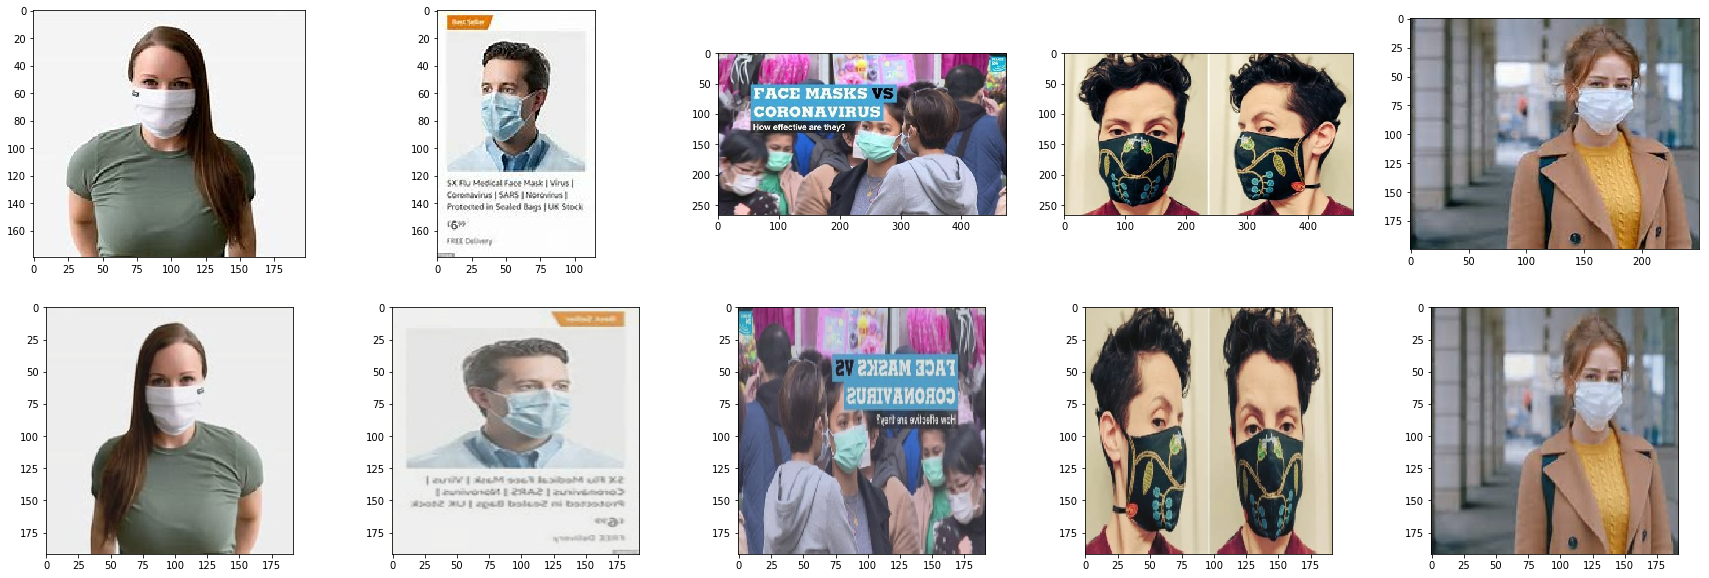

In [8]:
#Preprocessing vizualisation
nb = 5
fig, axes = plt.subplots(2,nb,figsize=(30, 10))

for i in range(nb):
    axes[0,i].imshow(ds_tensors[i])
    axes[1,i].imshow(preprocess_images(load_and_resize_images(ds_paths[i])).numpy())
    
plt.show()

In [44]:
#Création d'un tensorflow dataset
tf_ds = tf.data.Dataset.from_tensor_slices(ds_paths)

# Chargement et redimension des images
tf_ds = tf_ds.map(load_and_resize_images)

# Creation d'un tensorflow dataset pour les labels 
labels = [1] * mask_size
labels_nomask = [0]* nomask_size
labels.extend(labels_nomask)
print("Taille du dataset labels ",len(labels))

tf_labels = tf.data.Dataset.from_tensor_slices(labels)

# Concaténation des deux dataset (img et labels) 
full_ds = tf.data.Dataset.zip((tf_ds, tf_labels))

# Mélange du dataset & création des batchs 
full_ds = full_ds.shuffle(ds_size)

#TRAIN TEST SPLIT
TEST_SIZE = round(0.30*ds_size)

train_data = full_ds.skip(TEST_SIZE) #.shuffle()
#Dataaugmentation
train_data = train_data.map(lambda x, y: (preprocess_images(x), y))
print("Train data : ",len(list(train_data)))
train_data = train_data.batch(64)

test_data = full_ds.take(TEST_SIZE)

VAL_SIZE = round(0.15*ds_size)
val_data = test_data.take(VAL_SIZE)
print("Validation data : ",len(list(val_data)))
val_data = test_data.batch(64)

test_data = test_data.skip(VAL_SIZE)
print("Test data : ",len(list(test_data)))
test_data = test_data.batch(64)



Taille du dataset labels  2356
Train data :  1649
Validation data :  353
Test data :  354


# Model 2 (CNN) 

In [91]:
# Création d'un model 
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[192, 192, 3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"),
    tf.keras.layers.Dense(units=16, activation ="relu"),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])




In [92]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que 
# nous entrainons le modèle 
initial_learning_rate = 0.0005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=6000,
    decay_rate=0.95,
    staircase=True)

In [93]:
# Création d'un compileur
model2.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

In [94]:
# history va contenir les scores à la fin de chaque epoch sur:
# les données d'entraînement (données vues par le modele)
# les données de validation (données inconnues du modele)
import time

tps1 = time.clock()
print(tps1)

history = model2.fit(train_data, 
                    epochs=10,
                    validation_data = val_data)

tps2 = time.clock()
print(tps2)
print("Temps d'execution en sec: " ,tps2 - tps1)

6e-07
Epoch 1/10
26/26 [==============================] - 560s 22s/step - loss: 0.6527 - binary_accuracy: 0.6307 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
26/26 [==============================] - 525s 20s/step - loss: 0.5556 - binary_accuracy: 0.7168 - val_loss: 0.3977 - val_binary_accuracy: 0.8175
Epoch 3/10
26/26 [==============================] - 515s 20s/step - loss: 0.4441 - binary_accuracy: 0.7968 - val_loss: 0.4853 - val_binary_accuracy: 0.8034
Epoch 4/10
26/26 [==============================] - 526s 20s/step - loss: 0.4155 - binary_accuracy: 0.8181 - val_loss: 0.3189 - val_binary_accuracy: 0.8472
Epoch 5/10
26/26 [==============================] - 528s 20s/step - loss: 0.3835 - binary_accuracy: 0.8326 - val_loss: 0.3050 - val_binary_accuracy: 0.8713
Epoch 6/10
26/26 [==============================] - 525s 20s/step - loss: 0.3720 - binary_accuracy: 0.8441 - val_loss: 0.3456 - val_binary_accuracy: 0.8586
Epoch 7/10
26/26 [==============================] 

In [ ]:
import time

tps1 = time.clock()
print(tps1)

model2.evaluate(test_data)
tps2 = time.clock()
print(tps2)
print("Temps d'execution : " ,tps2 - tps1)

In [ ]:
nb = 2
fig, axes = plt.subplots(1,nb,figsize=(20, 10))

#Plot de la loss
axes[0].plot(history.history["loss"], color="b")
axes[0].plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

#Plot de l'accuracy
axes[1].plot(history.history["binary_accuracy"], color="b")
axes[1].plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()


In [ ]:
N = 10

plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [ ]:
y_true = []
y_pred = []
for batch, true_labels in test_data.take(-1):
  y_true += [true_labels.numpy()]
  y_pred += [model2.predict_classes(batch)]
    
y_true = tf.concat([batch for batch in y_true], axis=0).numpy()
y_pred = tf.concat([batch for batch in y_pred], axis=0).numpy()

from sklearn.metrics import confusion_matrix 
import seaborn as sns 

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
for example, label in test_data.take(1):
  y_pred = model2.predict_classes(example.numpy())
  
  for i in range(len(y_pred)):
    plt.figure()
    plt.title(y_pred[i])
    plt.imshow(example[i])
    
plt.show()

In [ ]:
model2.save("model2.h5")

# Model 3 - Transfert Learning avec Inception_v3

In [29]:
base_model = tf.keras.applications.InceptionV3(input_shape=(192,192,3), 
                                               include_top=False,
                                               weights = "imagenet")
#On ré-entraine les 75 dernières couches                                               
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# On adapte le model à notre dataset en ajoutant la dernière couche
model3 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])


# Vous devrez refaire tourner un model.compile avant de ré-entrainer le modèle 
'''model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])'''


history2 = model3.fit(train_data, epochs=15,validation_data = test_data)
#Sauvegarde du model                                               
model3.save("InceptionV3_75_mask_4.h5")

Epoch 1/15
28/28 [==============================] - 707s 25s/step - loss: 0.2024 - binary_accuracy: 0.9236 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/15
28/28 [==============================] - 663s 24s/step - loss: 0.0810 - binary_accuracy: 0.9734 - val_loss: 0.4818 - val_binary_accuracy: 0.8200
Epoch 3/15
28/28 [==============================] - 701s 25s/step - loss: 0.0430 - binary_accuracy: 0.9819 - val_loss: 1.6986 - val_binary_accuracy: 0.5857
Epoch 4/15
28/28 [==============================] - 811s 29s/step - loss: 0.0486 - binary_accuracy: 0.9836 - val_loss: 0.0690 - val_binary_accuracy: 0.9813
Epoch 5/15
28/28 [==============================] - 1307s 47s/step - loss: 0.0323 - binary_accuracy: 0.9881 - val_loss: 0.2892 - val_binary_accuracy: 0.9168
Epoch 6/15
28/28 [==============================] - 1371s 49s/step - loss: 0.0340 - binary_accuracy: 0.9921 - val_loss: 0.0826 - val_binary_accuracy: 0.9745
Epoch 7/15
28/28 [==============================] - 14

In [45]:
############# CHEKPOINT MODEL #################
#from tf.keras.callbacks import ModelCheckpoint

base_model = tf.keras.applications.InceptionV3(input_shape=(192,192,3), 
                                               include_top=False,
                                               weights = "imagenet")
#On ré-entraine les 50 dernières couches                                               
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# On adapte le model à notre dataset en ajoutant la dernière couche
model3 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

# checkpoint
filepath="weights.best30.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Vous devrez refaire tourner un model.compile avant de ré-entrainer le modèle 
'''model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])'''


history = model3.fit(train_data, epochs=30,validation_data = val_data,callbacks=callbacks_list)
#Sauvegarde du model                                               
model3.save("InceptionV3_75_mask_30.h5")

Epoch 1/30
     26/Unknown - 1394s 54s/step - loss: 0.2222 - binary_accuracy: 0.9133
Epoch 00001: val_binary_accuracy improved from -inf to 0.79349, saving model to weights.best30.hdf5
26/26 [==============================] - 1693s 65s/step - loss: 0.2222 - binary_accuracy: 0.9133 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/30
25/26 [===========================>..] - ETA: 47s - loss: 0.0761 - binary_accuracy: 0.9712 
Epoch 00002: val_binary_accuracy did not improve from 0.79349
26/26 [==============================] - 1487s 57s/step - loss: 0.0763 - binary_accuracy: 0.9697 - val_loss: 2.2094 - val_binary_accuracy: 0.5149
Epoch 3/30
25/26 [===========================>..] - ETA: 46s - loss: 0.0713 - binary_accuracy: 0.9762 
Epoch 00003: val_binary_accuracy did not improve from 0.79349
26/26 [==============================] - 1455s 56s/step - loss: 0.0714 - binary_accuracy: 0.9751 - val_loss: 32.9698 - val_binary_accuracy: 0.4950
Epoch 4/30
25/26 [====================

KeyboardInterrupt: 

In [47]:
#PLOT DE l'APPRENTISSAGE
'''
N = 15

plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_best_model30")''''''

### Evaluation du modèle

In [ ]:
model3.load_weights("weights.best30.hdf5")
import time

tps1 = time.clock()

model3.evaluate(test_data)
tps2 = time.clock()

print("Temps d'execution : " ,tps2 - tps1)

model3.evaluate(val_data)

### Matrice de confusion

In [48]:

y_true = []
y_pred = []
for batch, true_labels in test_data.take(-1):
  y_true += [true_labels.numpy()]
  y_pred += [model3.predict_classes(batch)]
    
y_true = tf.concat([batch for batch in y_true], axis=0).numpy()
y_pred = tf.concat([batch for batch in y_pred], axis=0).numpy()

from sklearn.metrics import confusion_matrix 
import seaborn as sns 

cm = confusion_matrix(y_true, y_pred)


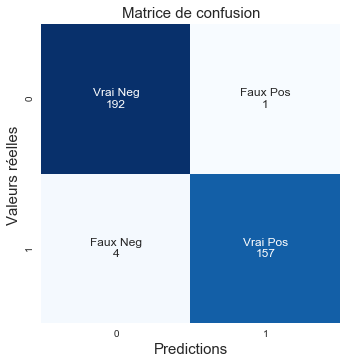

In [84]:
plt.figure()
group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='',cmap='Blues',cbar=False, square = True)
plt.title('Matrice de confusion', fontsize = 15)
plt.xlabel('Predictions', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Valeurs réelles ', fontsize = 15) # y-axis label with fontsize 15
plt.show()

# Model 4 : Transfert learning avec Resnet50

In [87]:
############# CHEKPOINT MODEL #################
#from tf.keras.callbacks import ModelCheckpoint
#from keras.applications.resnet50 import ResNet50
#model4 = ResNet50(include_top=True, weights='imagenet')

base_model = tf.keras.applications.ResNet50(input_shape=(192,192,3), 
                                               include_top=False,
                                               weights = "imagenet")
#On ré-entraine les 50 dernières couches                                               
base_model.trainable = False
'''fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False'''

# On adapte le model à notre dataset en ajoutant la dernière couche
model4 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

# checkpoint
filepath="weights.bestresnet50.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Vous devrez refaire tourner un model.compile avant de ré-entrainer le modèle 
'''model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])'''


history = model4.fit(train_data, epochs=30,validation_data = val_data,callbacks=callbacks_list)
#Sauvegarde du model                                               
model3.save("ResNet50_mask_30.h5")

94773248/94765736 [==============================] - 6s 0us/step
Epoch 1/30
      5/Unknown - 541s 108s/step - loss: 0.6855 - binary_accuracy: 0.6055WARNING:tensorflow:Can save best model only with val_binary_accuracy available, skipping.
      5/Unknown - 541s 108s/step - loss: 0.6855 - binary_accuracy: 0.6055

KeyboardInterrupt: 

## Model 5 : SqueezeNet

In [90]:
############# CHEKPOINT MODEL #################
base_model = tf.keras.applications.ResNet18(input_shape=(192,192,3), 
                                               include_top=False,
                                               weights = "imagenet")
#On ré-entraine les 50 dernières couches                                               
base_model.trainable = False
'''fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False'''

# On adapte le model à notre dataset en ajoutant la dernière couche
model5 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

# checkpoint
#filepath="weights.bestresnet50.hdf5"
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

history = model5.fit(train_data, epochs=5,validation_data = val_data) #,callbacks=callbacks_list
#Sauvegarde du model                                               
model5.save("Resnet18_mask_5.h5")

AttributeError: module 'tensorflow_core.keras.applications' has no attribute 'ResNet18'